In [62]:
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np

In [78]:
# initialization
num_rows = 4
num_cols = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 200  # number of epochs of training
batch_size = 64  # size of the batches
learning_rate = 0.0002  # adam: learning rate
b1 = 0.5  # adam: decay of first order momentum of gradient
b2 = 0.999  # adam: decay of first order momentum of gradient
n_cpu = 8  # number of cpu threads to use during batch generation
latent_dim = 100  # dimensionality of the latent space
img_size = 32  # size of each image dimension
channels = 1  # number of image channels
sample_interval = 400  # interval between image sampling

In [79]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [80]:
# discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def discriminator_block(in_filters,out_filters,bn=False):
          block = [nn.Conv2d(in_filters,out_filters,3,2,1),nn.LeakyReLU(0.2,inplace=True),nn.Dropout2d(0.25)]
          if bn:
            return block.append(nn.BatchNorm2d(out_filters, 0.8))
          return block

        self.model =   nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
          )
        ds_size = img_size//2 **4
        self.adv_layer = nn.Sequential(nn.Linear(128* ds_size **2,1),nn.Sigmoid())

    def forward(self,img):
        out = self.model(img)
        out = out.view(out.shape[0],-1)
        validity = self.adv_layer(out)
        
        return validity

In [81]:
dataset = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./dataset/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [82]:
# optimization

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

loss_fn = nn.BCELoss().to(device)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(),lr=learning_rate,betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(),lr=learning_rate,betas=(b1,b2))

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Tensor = torch.cuda.FloatTensor if device == 'cuda' else torch.FloatTensor


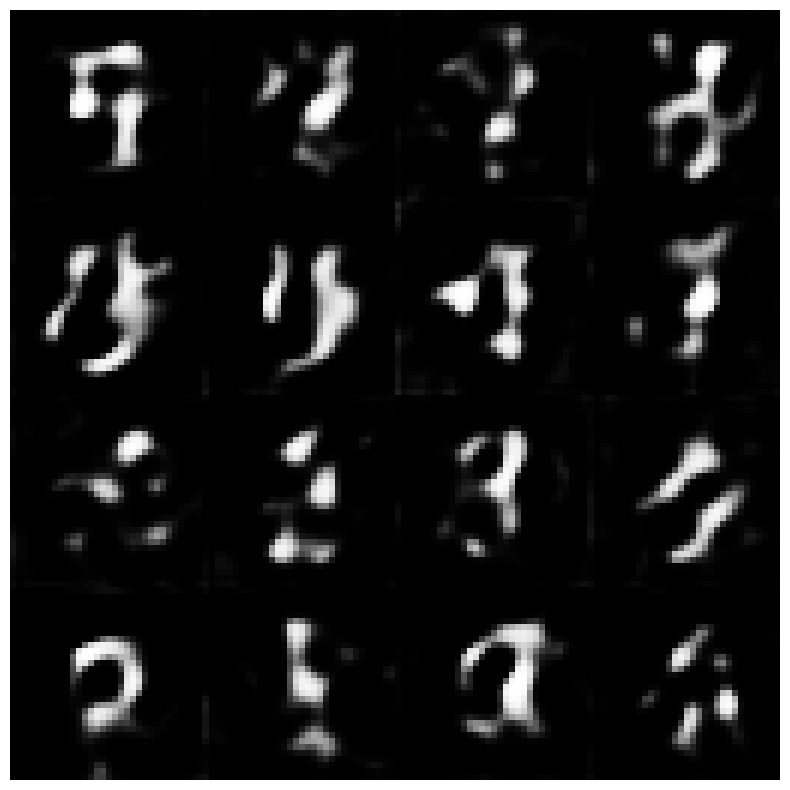

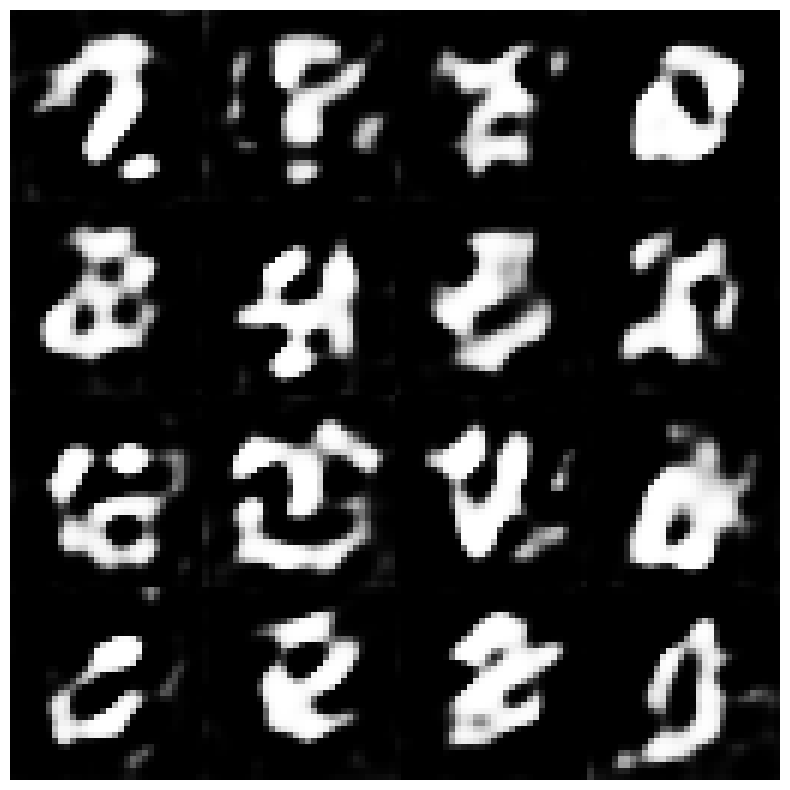

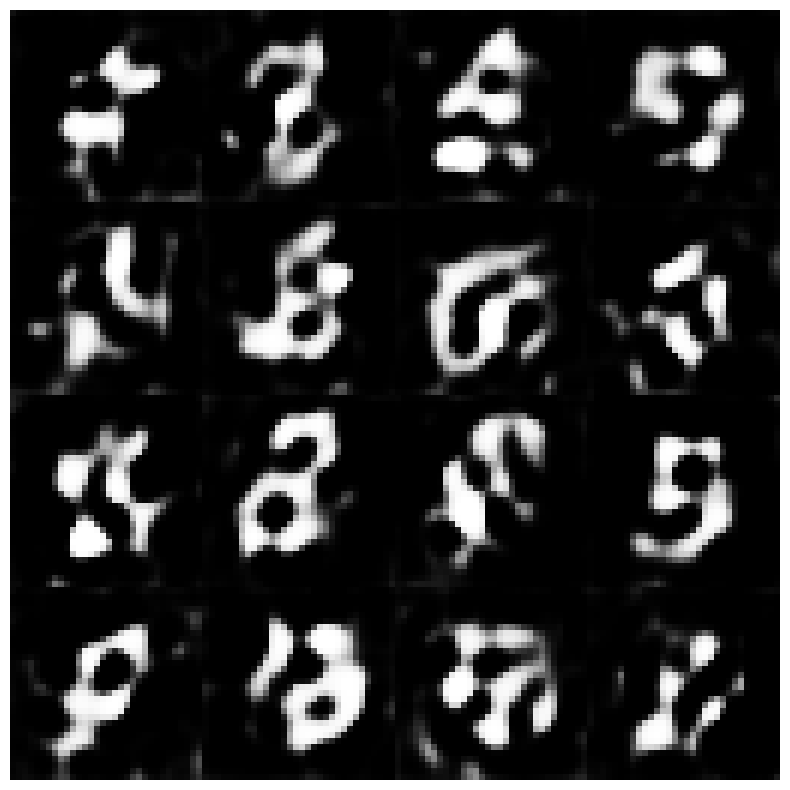

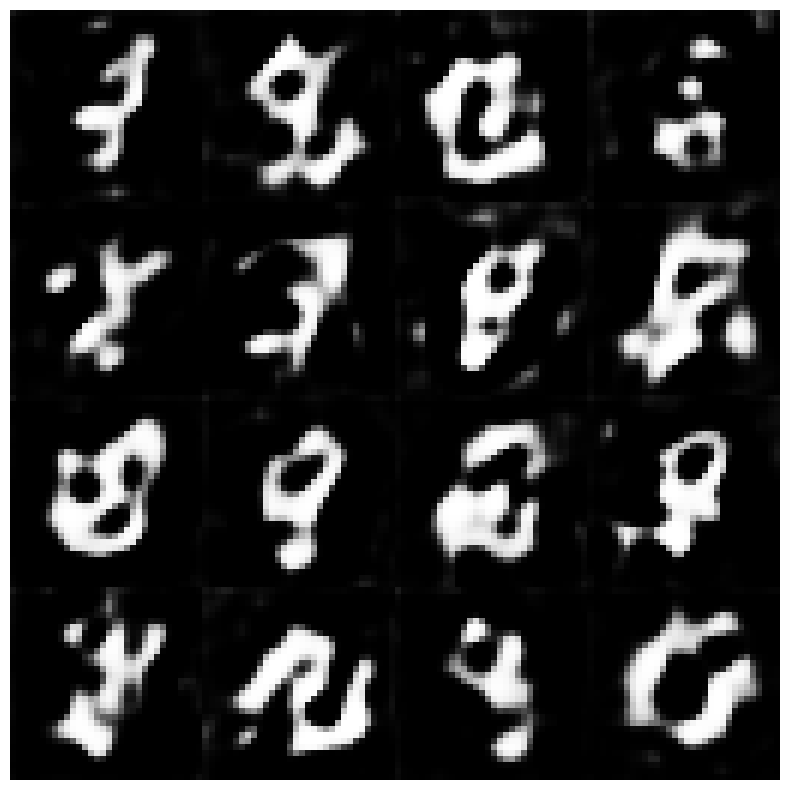

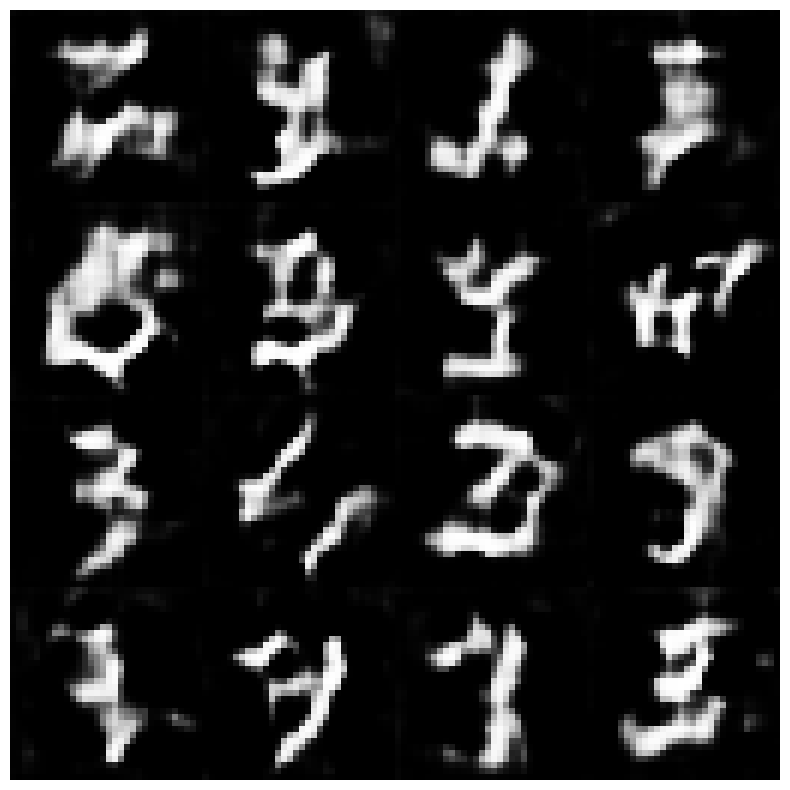

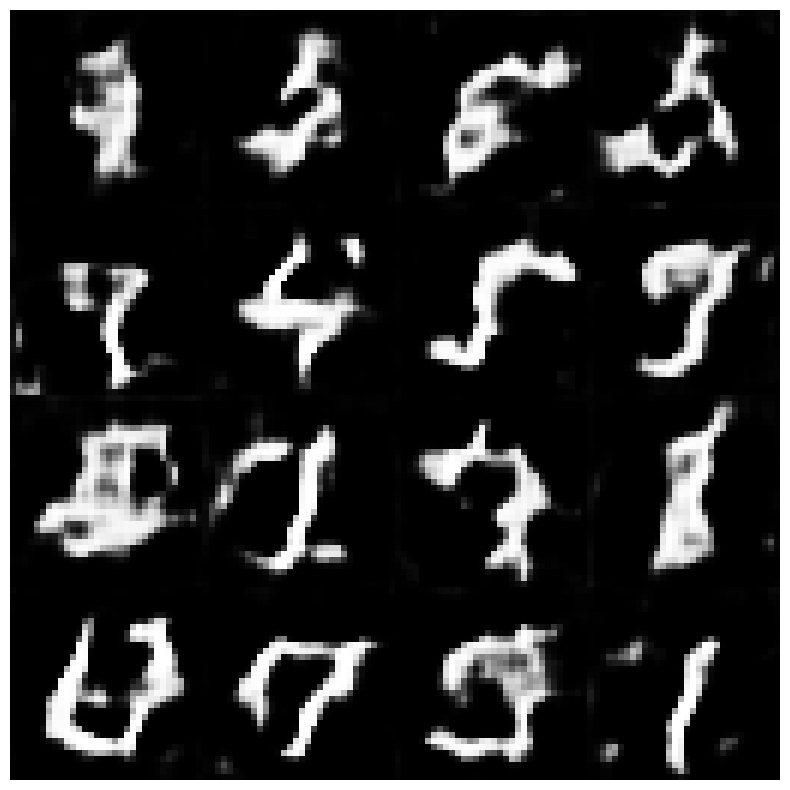

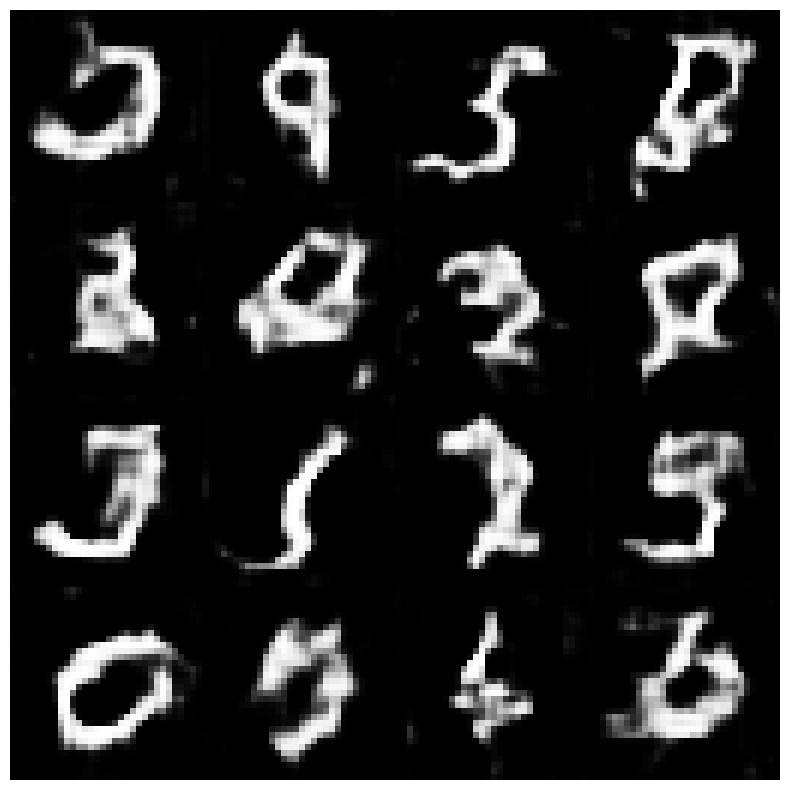

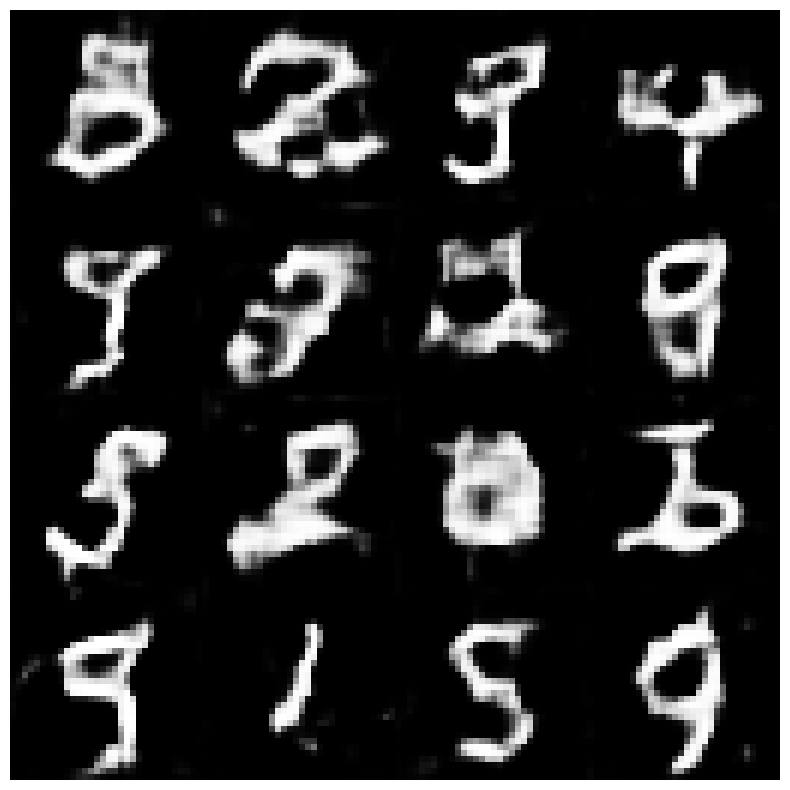

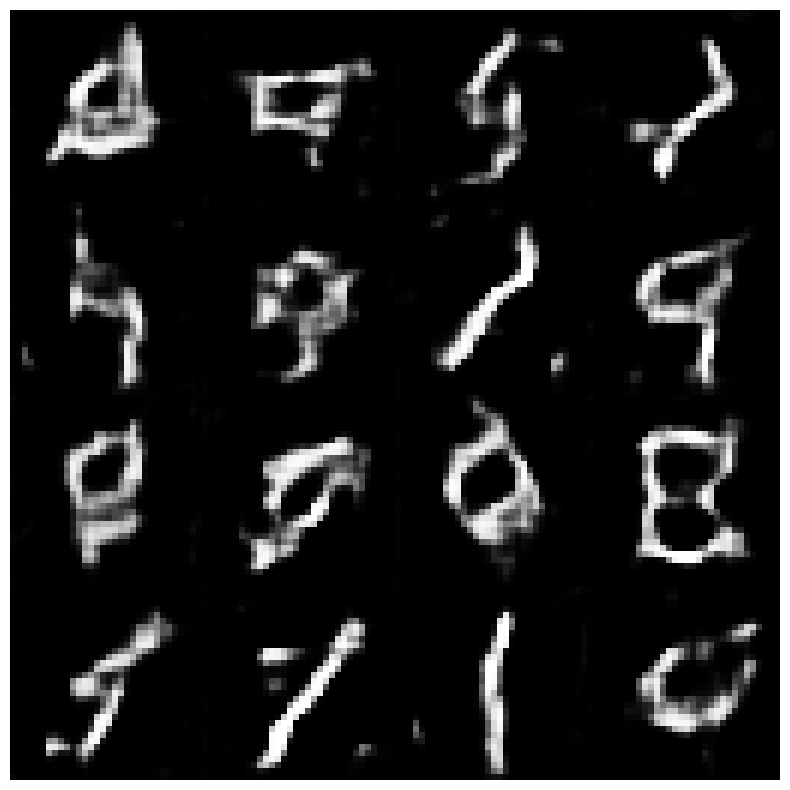

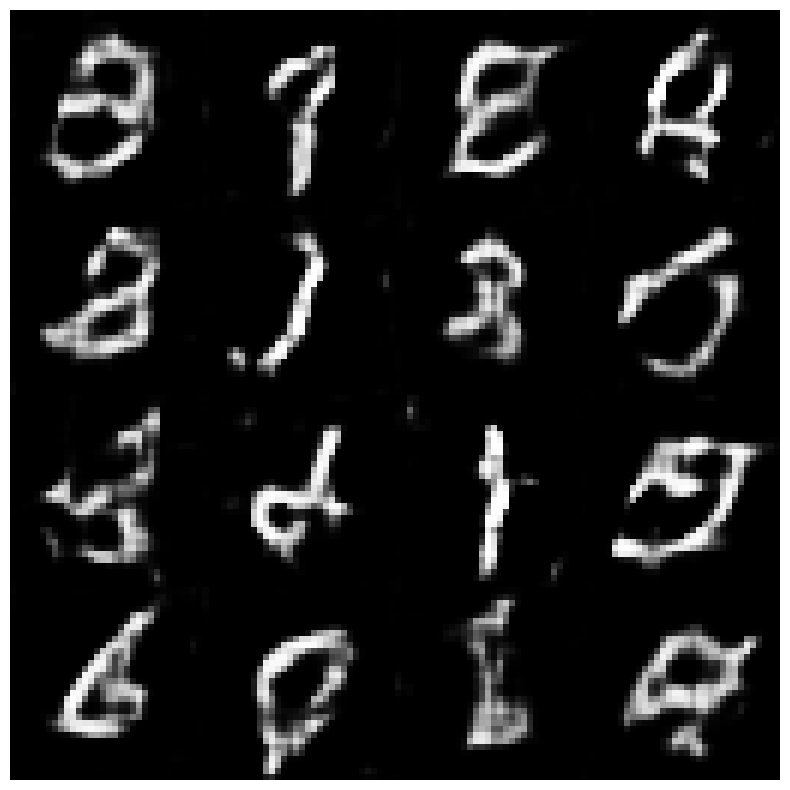

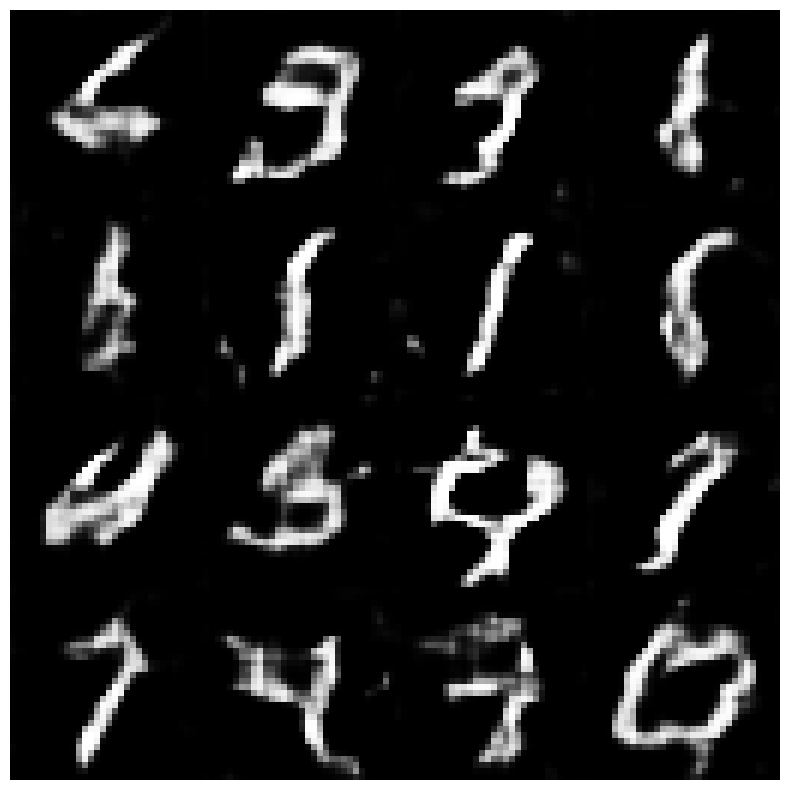

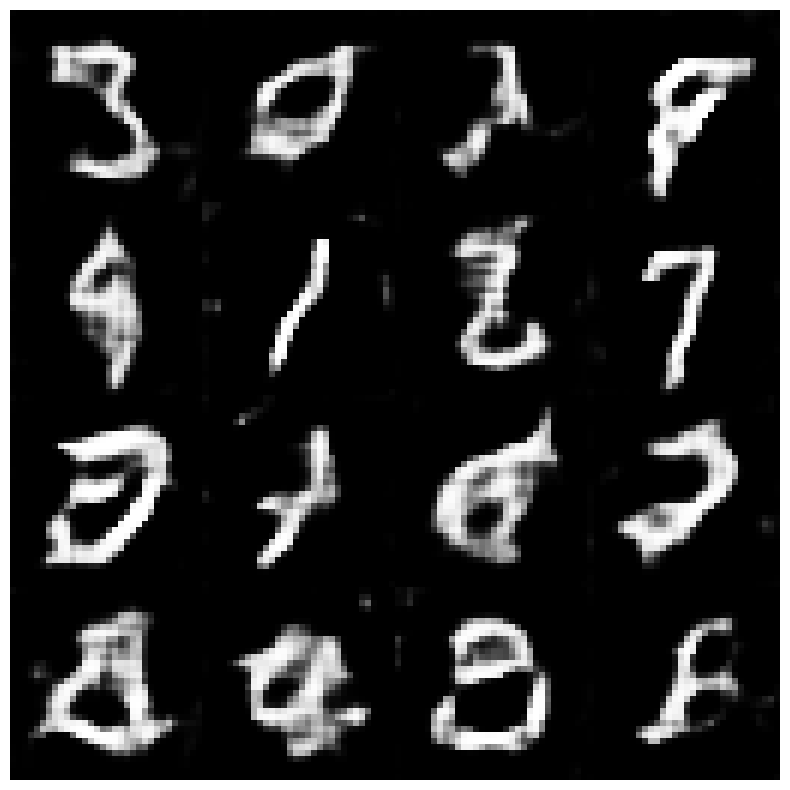

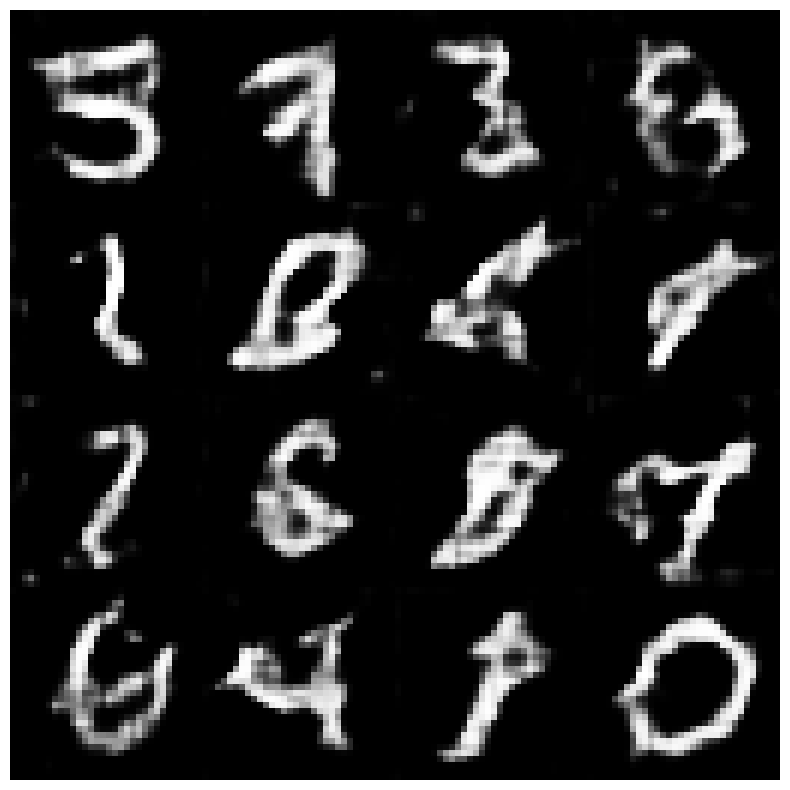

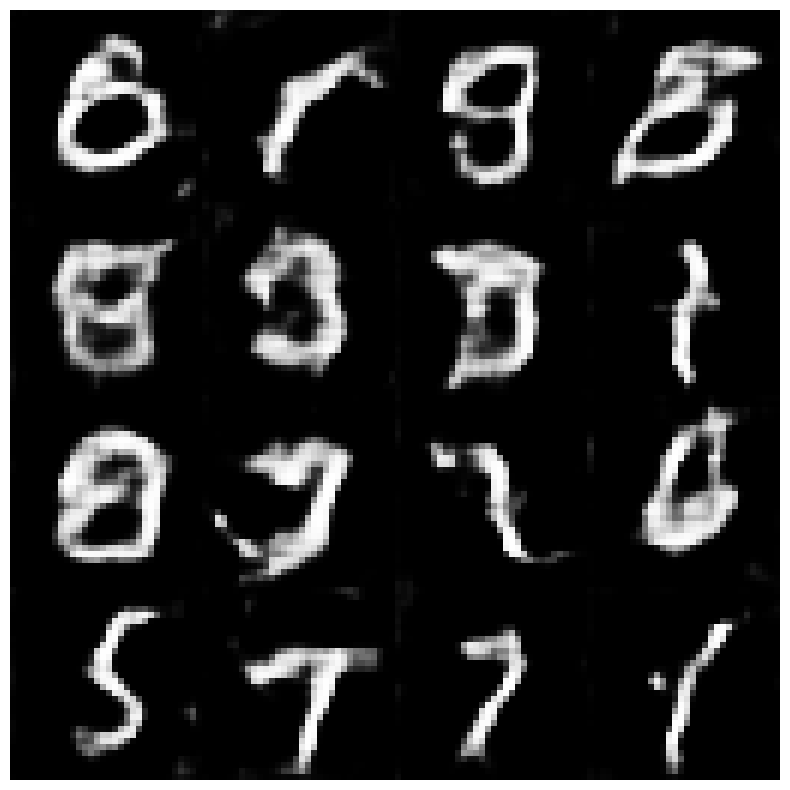

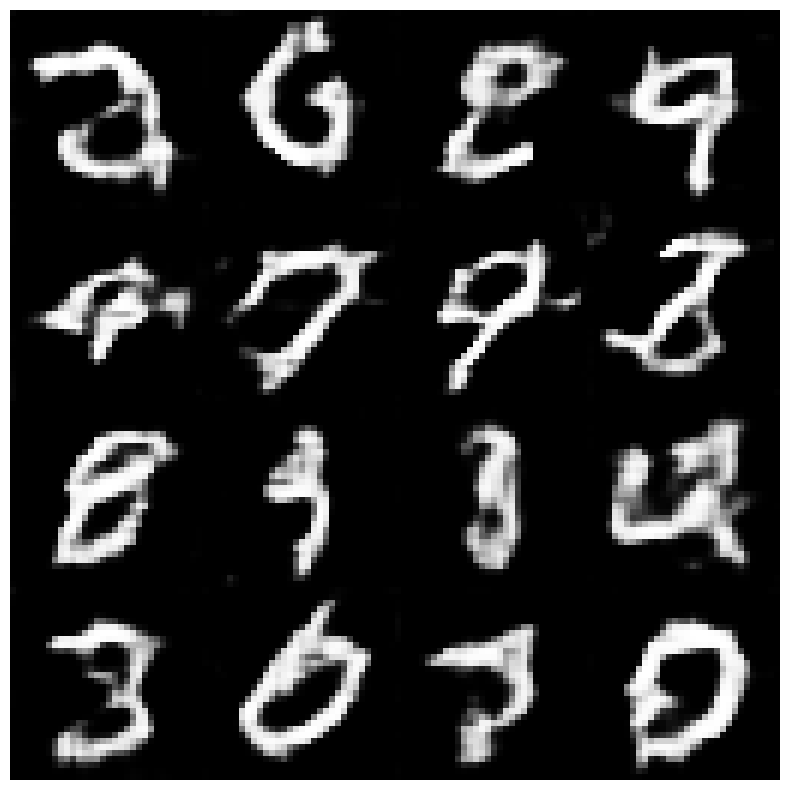

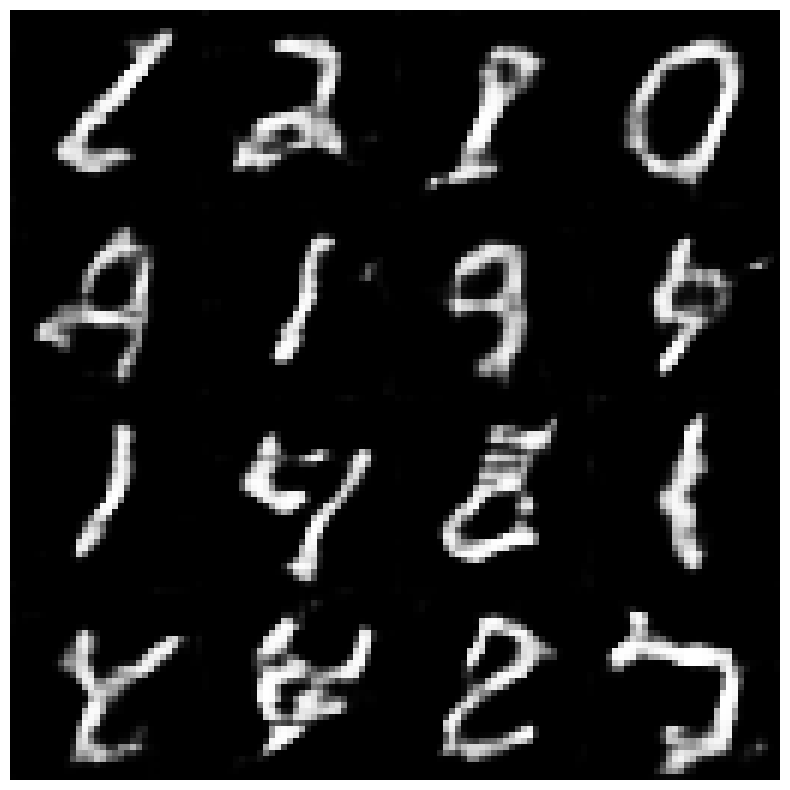

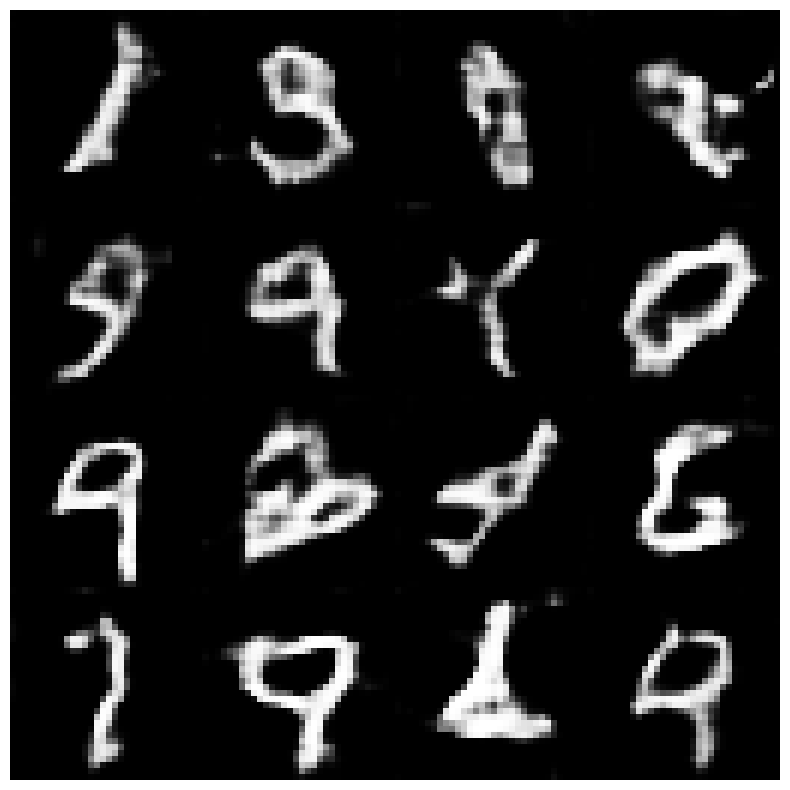

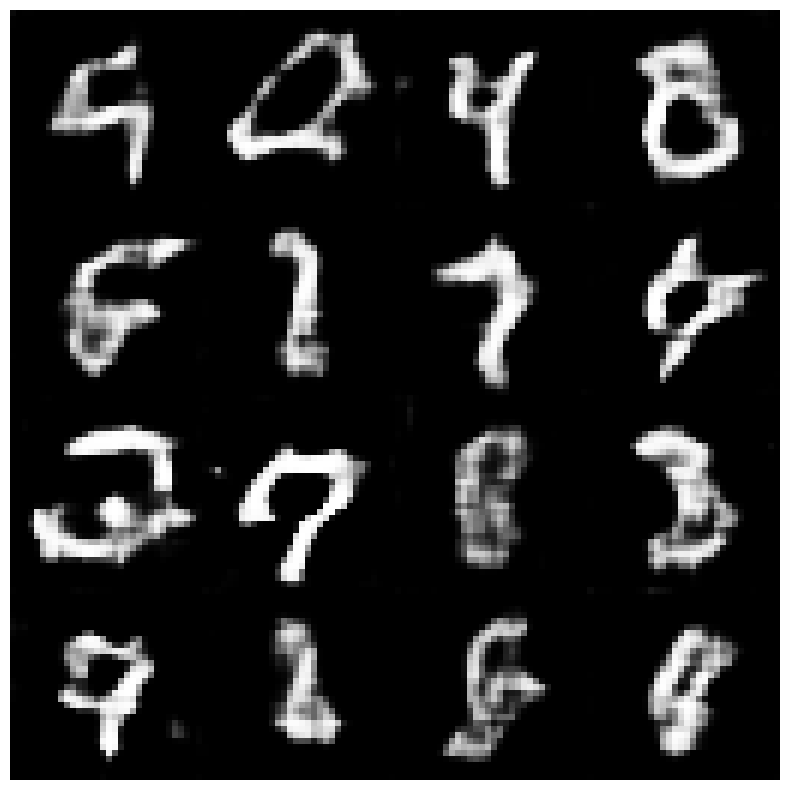

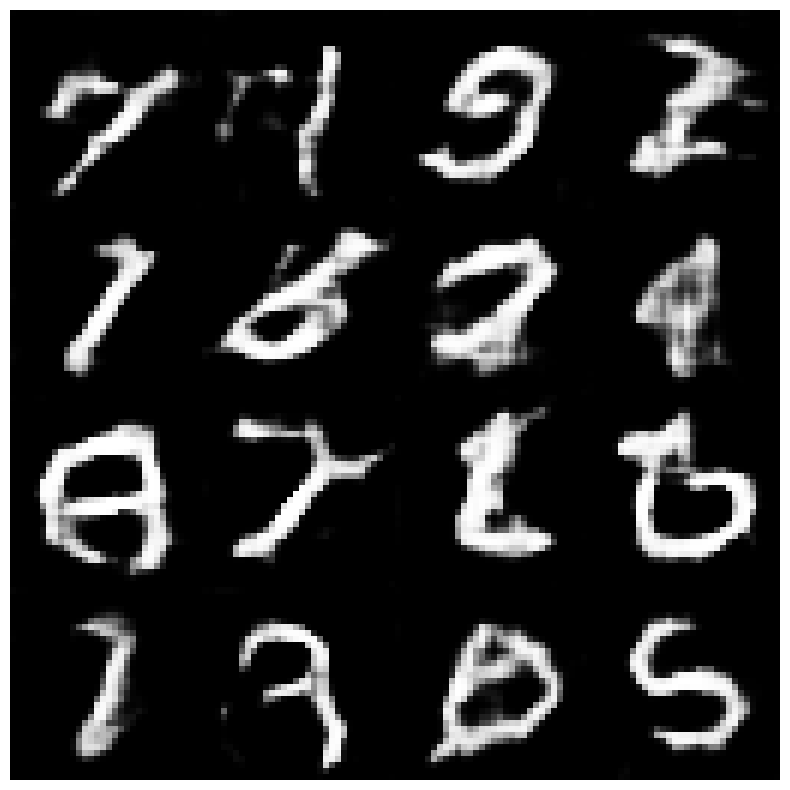

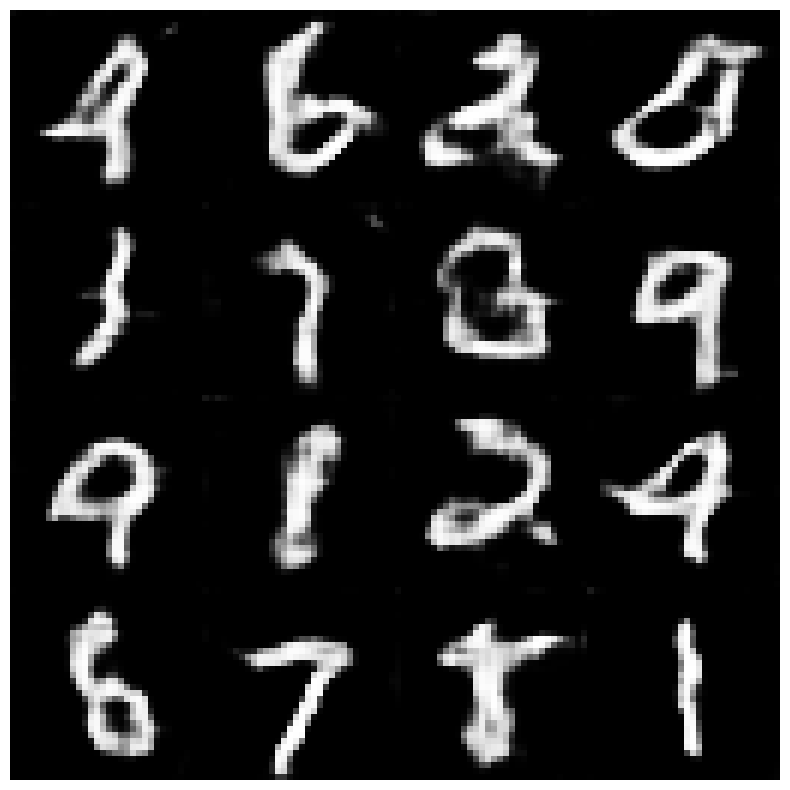

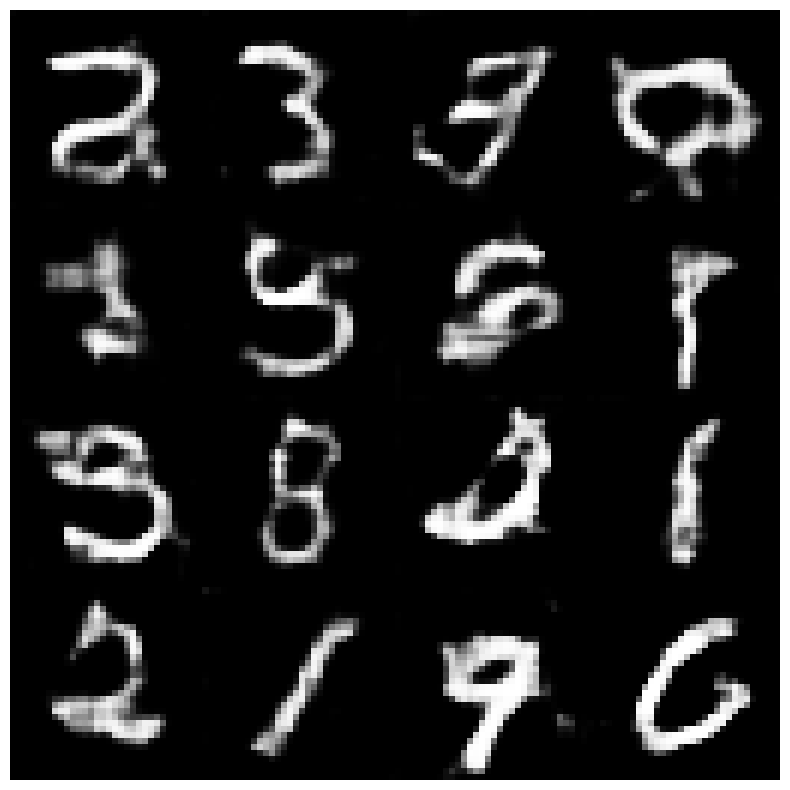

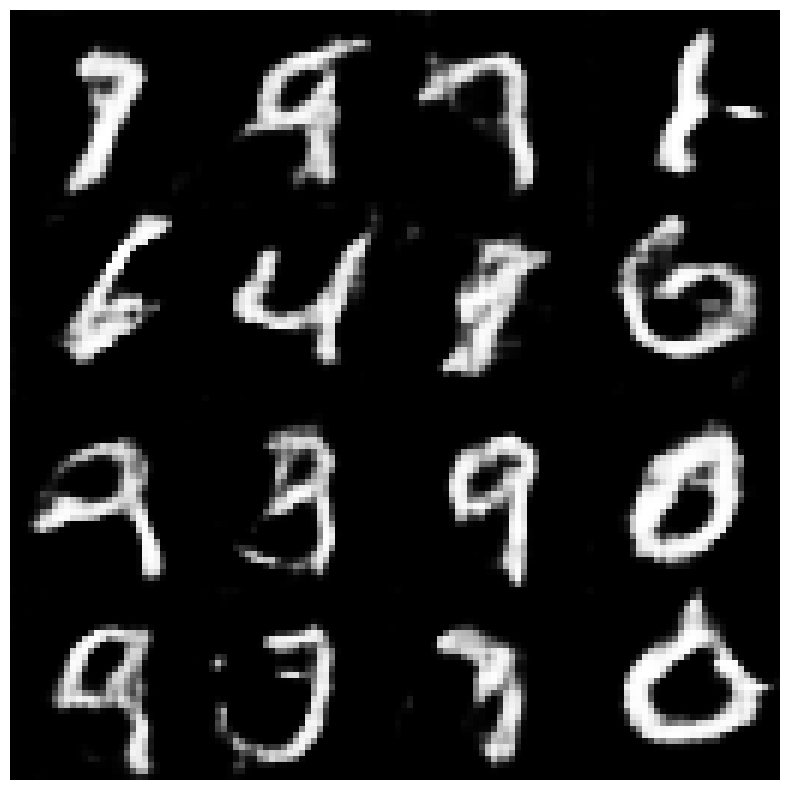

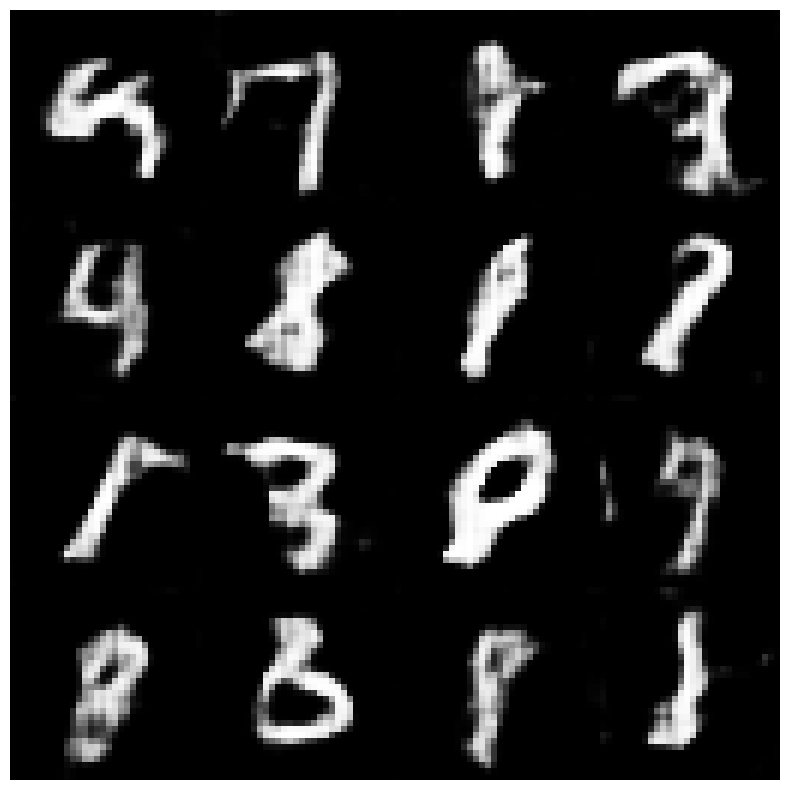

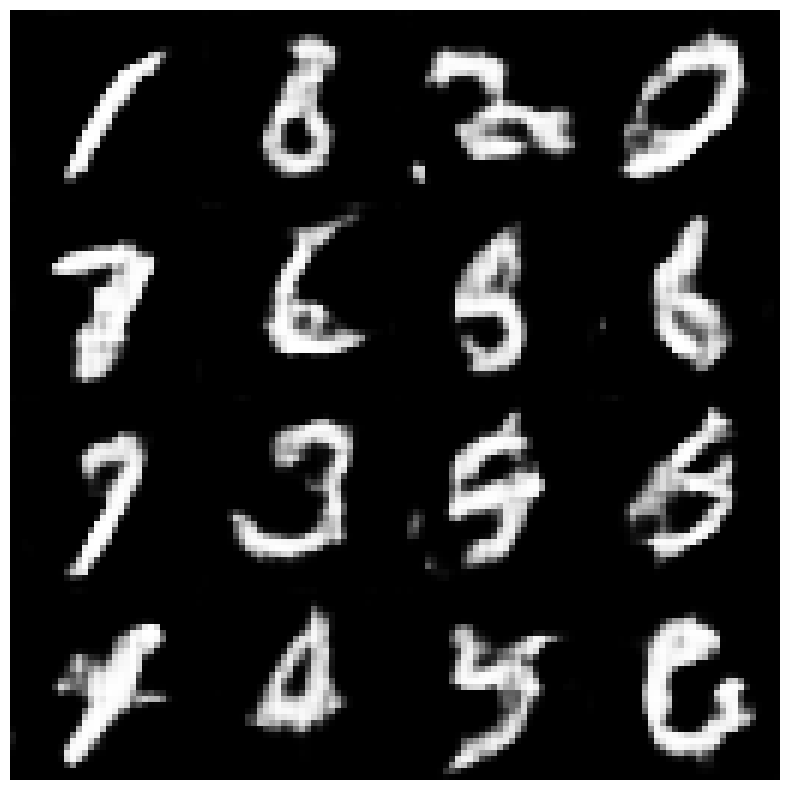

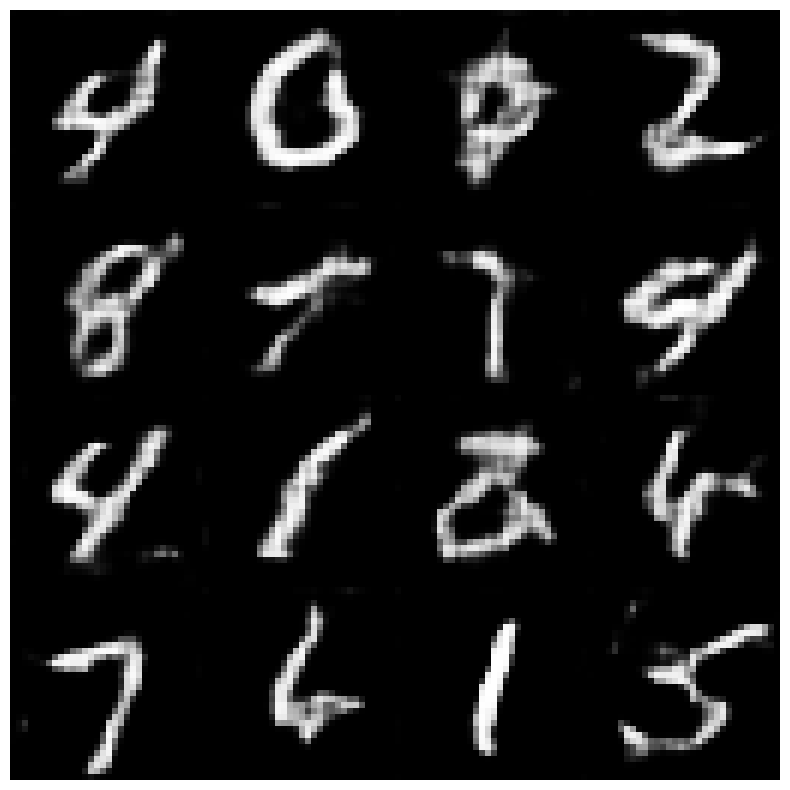

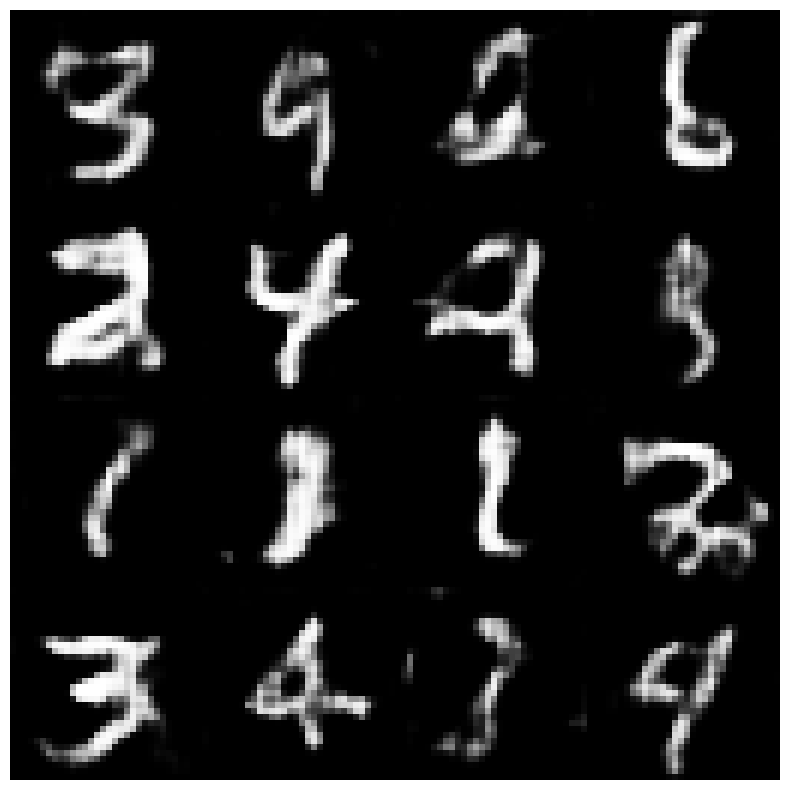

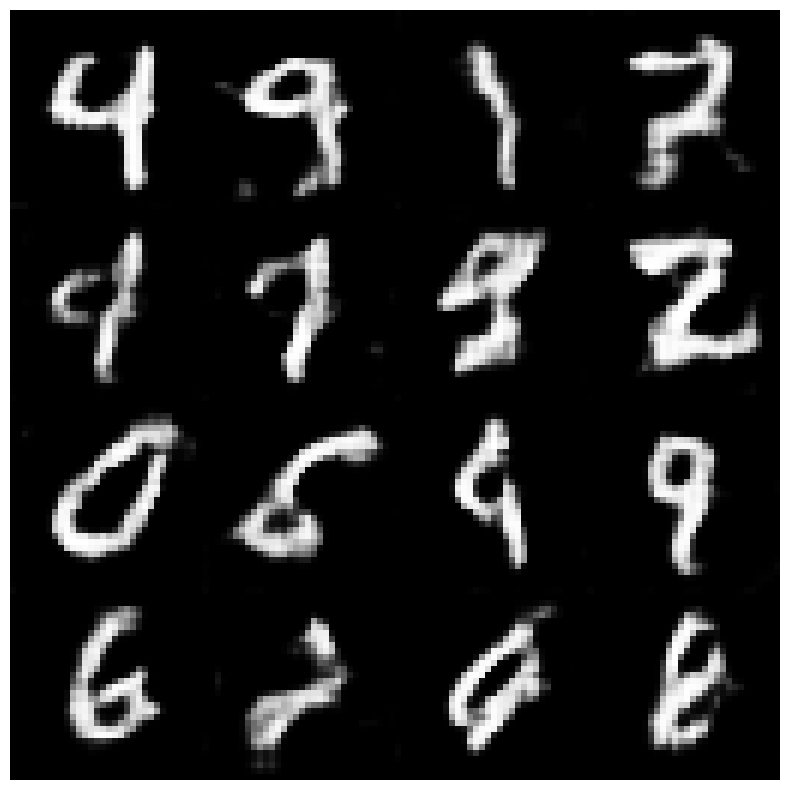

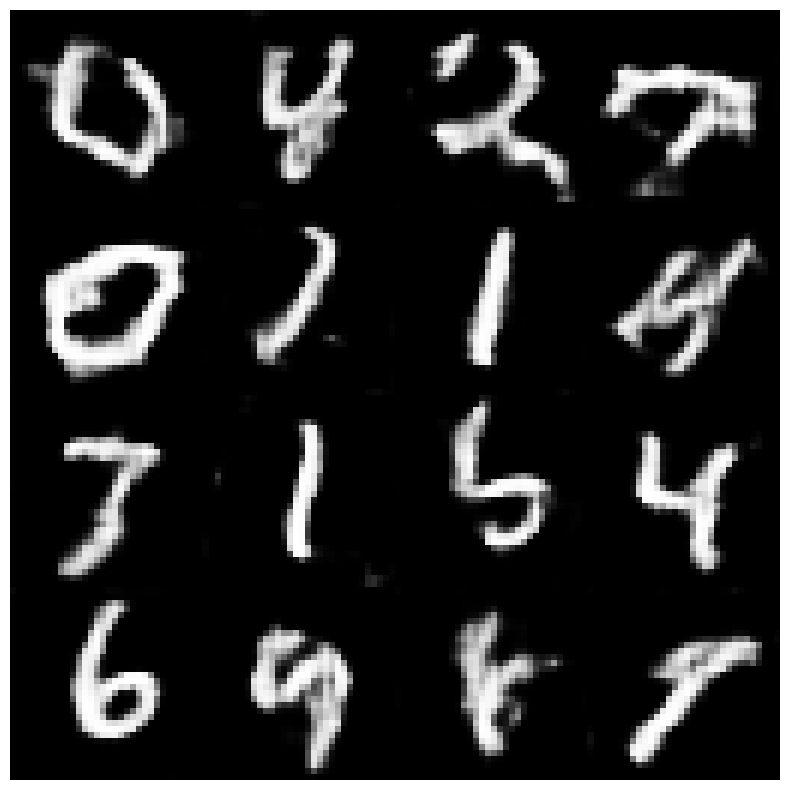

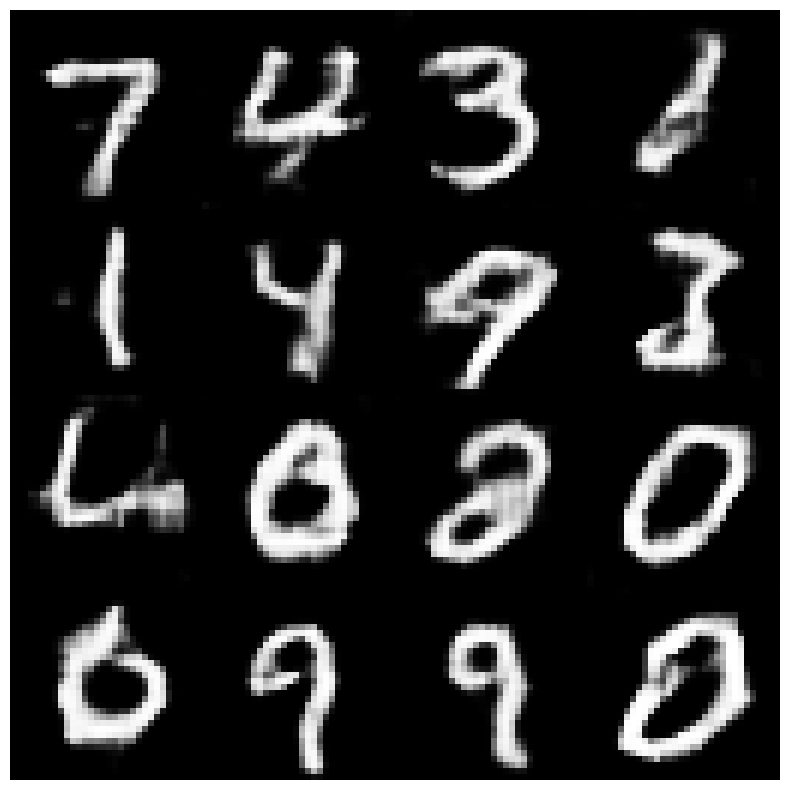

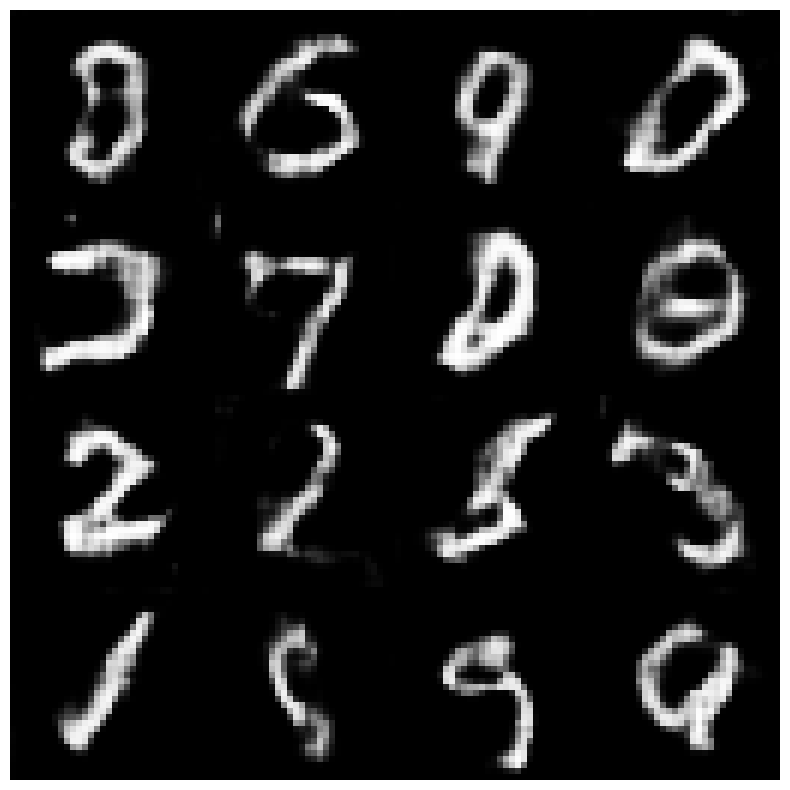

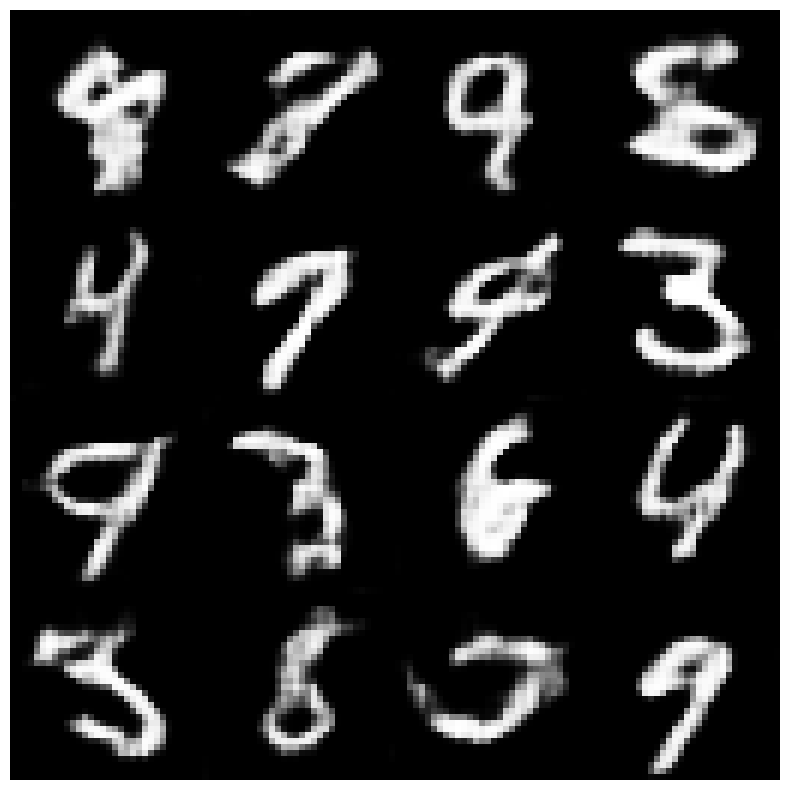

In [ ]:
# Training Loop

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataset):
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(Tensor))

        # train generator
        optimizer_G.zero_grad()

        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))  # Corrected syntax error

        gen_imgs = generator(z)

        g_loss = loss_fn(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # train discriminator
        optimizer_D.zero_grad()

        real_loss = loss_fn(discriminator(real_imgs), valid)  # Corrected syntax error
        fake_loss = loss_fn(discriminator(gen_imgs.detach()), fake)  # Corrected syntax error

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        #       % (epoch, num_epochs, i, len(dataset), d_loss.item(), g_loss.item())
        #       )

        batches_done = epoch * len(dataset) + i

        if batches_done % sample_interval == 0:
            gen_imgs_numpy = gen_imgs.data[:num_rows*num_cols].cpu().numpy()

            gen_imgs_numpy = 0.5 * (gen_imgs_numpy + 1)  

            gen_imgs_numpy = gen_imgs_numpy.reshape(num_rows, num_cols, img_size, img_size, channels)
            gen_imgs_numpy = gen_imgs_numpy.transpose(0, 2, 1, 3, 4).reshape(num_rows * img_size, num_cols * img_size, channels)

            plt.figure(figsize=(10, 10))
            plt.imshow(gen_imgs_numpy.squeeze(), cmap='gray' if channels == 1 else None)
            plt.axis('off')
            plt.show()
